    Observation: 
        Type: Box(4)
        Num	Observation                 Min         Max
        0	Cart Position             -4.8            4.8
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                 -24 deg        24 deg
        3	Pole Velocity At Tip      -Inf            Inf
        
    Actions:
        Type: Discrete(2)
        Num	Action
        0	Push cart to the left
        1	Push cart to the right
        
        
        
We give the 4 observations as an input and let the machine decide what to do
Markov Decision Process

	M = (S, A, P, R, y)
	S = Observation (Cart position, cart velocity, pole angle, pole velocity at tip)
	A = Actions (0, 1)
	P = transition probablity function
	R = reward function
    y = discounting factor for future rewards 


Markov

Temporal Difference learning

Q-Learning/SARSA

In [7]:
import numpy as np

import gym
from gym import wrappers

n_states = 50
iter_max = 5000

alpha = 0.2
gamma = 0.9
t_max = 500
# later 0.1
eps = 0.02

# Used to check model
def run_episode(env, policy=None, render=False):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    for _ in range(t_max):
        if render:
            env.render()
        if policy is None:
            action = env.action_space.sample()
        else:
            a,b,c,d = obs_to_state(env, obs)
            action = policy[a][b][c][d]
        obs, reward, done, _ = env.step(action)
        total_reward += gamma ** step_idx * reward
        step_idx += 1
        if done:
            break
    return total_reward

def obs_to_state(env, obs):
    """ Maps an observation to state """
    # Splits the observations ranges into equal chunks, different values fall into these chunks
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_dx = (env_high - env_low) / n_states
    # Cart position and Pole velocity were always at 0 so I removed them for simplicity
    # Add back
    a = int((obs[0] - env_low[0])/env_dx[0])
    b = int((obs[1] - env_low[1])/env_dx[1])
    c = int((obs[2] - env_low[2])/env_dx[2])
    d = int((obs[3] - env_low[3])/env_dx[3])
#     print(a, obs[0], env_low[0], env_dx[0])
#     print(b, obs[1], env_low[1], env_dx[1])
#     print(c, obs[2], env_low[2], env_dx[2])
#     print(d, obs[3], env_low[3], env_dx[3])
    return a, b, c, d

if __name__ == '__main__':
    env = gym.make('CartPole-v1').env

    # Creating the table
    # Each possible action a has its own matrix, with each action b assigned to an array in that matrix
    # Inside each array has two values, the expected reward when choosing to go left
    # and the expected reward when choosing to go right
    
    # make random
    q_table = np.zeros((n_states, n_states, n_states, n_states, 2))

    for i in range(iter_max):
        obs = env.reset()
        total_reward = 0
        
#         env.render()
        
        for j in range(t_max):
            a, b, c, d = obs_to_state(env, obs)
            
#             print(a, b, obs, action)
#             print(a,b)

            # Randomly choose an option 1/5 of the time, eps = 0.2
            if np.random.uniform(0, 1) < eps:
                action = np.random.choice(env.action_space.n)
            else:
                # Can remove this random selection as we already have it from above
                # Gives a 3 length array, [action1, action2, action3]
                # Each Gives the expect reward at the next stage
                # Left, Right, Not Moving
                logits = q_table[a][b][c][d]
                # This section is used to choose an action with weighted random selection
                
                # Need to get the probabilities in the array to add to 1
                # np.exp calculates the exponential of everything in the array
                logits_exp = np.exp(logits)
                probs = logits_exp / np.sum(logits_exp)
                
                # Choose an action with weighted random selection
                action = np.random.choice(env.action_space.n, p=probs)
            
            # Get next state info
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            
            # updating q table
            # a_, b_ are the next state
            a_,b_,c_,d_ = obs_to_state(env, obs)
                        
            cur_action = q_table[a][b][c][d][action]
            next_action = np.max(q_table[a_][b_][c_][d_])

            if done:
                break
            
            # Using eta to learn faster at the start
            # Taking the best expected reward from
            # the next state + actual reward - the expected reward from the current action
            q_table[a][b][c][d][action] = cur_action + alpha * (reward + (gamma *  next_action) - cur_action)


        if i % 200 == 0:
            print('Iteration #%d -- Total reward = %d.' %(i+1, total_reward))

/Users/euan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in subtract


Iteration #1 -- Total reward = 9.
Iteration #201 -- Total reward = 18.
Iteration #401 -- Total reward = 17.
Iteration #601 -- Total reward = 10.
Iteration #801 -- Total reward = 15.
Iteration #1001 -- Total reward = 17.
Iteration #1201 -- Total reward = 42.
Iteration #1401 -- Total reward = 13.
Iteration #1601 -- Total reward = 20.
Iteration #1801 -- Total reward = 22.
Iteration #2001 -- Total reward = 17.
Iteration #2201 -- Total reward = 17.
Iteration #2401 -- Total reward = 21.
Iteration #2601 -- Total reward = 35.
Iteration #2801 -- Total reward = 10.
Iteration #3001 -- Total reward = 16.
Iteration #3201 -- Total reward = 21.
Iteration #3401 -- Total reward = 45.
Iteration #3601 -- Total reward = 29.
Iteration #3801 -- Total reward = 11.
Iteration #4001 -- Total reward = 13.
Iteration #4201 -- Total reward = 16.
Iteration #4401 -- Total reward = 10.
Iteration #4601 -- Total reward = 23.
Iteration #4801 -- Total reward = 18.


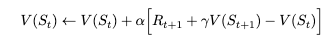

In [ ]:
            if done:
                if j == 500:
                    break
                else:
                    reward = 100
                    # Add a alpha, to slow learning rate (0.2)
                    # Lower gamma (0.9)
                    q_table[a][b][c][d][action] = cur_action + alpha * (reward + (gamma *  next_action) - cur_action)
                    break

In [6]:
# Testing the model
solution_policy = np.argmax(q_table, axis=4)
solution_policy_scores = [run_episode(env, solution_policy, False) for _ in range(1000)]
print("Average score of solution = ", np.mean(solution_policy_scores))

/Users/euan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in subtract


Average score of solution =  7.865593175652522


In [6]:
q_table[100][100]

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       ...,

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]])

In [ ]:
env.action_space

In [ ]:
env.observation_space.low

In [ ]:
np.random.uniform(0, 1)

In [ ]:
np.random.choice(env.action_space.n)

In [ ]:
test = np.random.uniform(0, -1, 3)

In [ ]:
test

In [ ]:
exp_test = np.exp(test)

In [ ]:
exp_test

In [ ]:
                logits_exp = np.exp(logits)
                probs = logits_exp / np.sum(logits_exp)
                action = np.random.choice(env.action_space.n, p=probs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward

In [ ]:
p_test = exp_test / np.sum(exp_test)

In [ ]:
p_test

In [ ]:
np.random.choice(3, p=p_test)

In [ ]:
np.random.choice(5, 3, p=[0.1, 0, 0.9, 0, 0])

In [ ]:
np.max(p_test)

In [ ]:
    # Animate it
#     run_episode(env, solution_policy, True)